In [21]:
from numba import jit
import numpy as np
import os
import pandas as pd


def trim_borders(array, top=0, bottom=0, left=0, right=0):
    if len(array.shape) != 2:
        raise ValueError("Input array must be 2D")

    return array[top : array.shape[0] - bottom, left : array.shape[1] - right]


@jit(nopython=True)
def fix_borders(grid):
    y1 = grid.shape[1] - 1

    for x1 in range(grid.shape[0]):
        grid[x1, y1] = grid[x1, y1 - 1]
        grid[x1, 0] = grid[x1, 1]
    x2 = grid.shape[0] - 1
    for y2 in range(grid.shape[1]):
        grid[x2, y2] = grid[x2 - 1, y2]
        grid[0, y2] = grid[1, y2]

    return grid


# Function to load and preprocess data
def load_data(directory, limit=-1):
    data = []
    i = 0
    for filename in os.listdir(directory):
        if limit > 0 and i == limit:
            break
        if filename.endswith(".csv"):
            filepath = os.path.join(directory, filename)
            df = pd.read_csv(filepath, header=None)
            data.append(
                # trim_borders(df.values, top=1, bottom=1, left=1, right=1)
                fix_borders(trim_borders(df.values, top=1, bottom=1, left=1, right=1))
            )
            if i % 50 == 0:
                print(f"Loaded {i} files")
            i += 1
    return np.array(data)


def compress_array_by_factor(original_array, factor=5):
    old_size = original_array.shape
    new_size = (old_size[0] // factor, old_size[1] // factor)

    compressed_array = np.zeros(new_size, dtype=float)

    for i in range(new_size[0]):
        for j in range(new_size[1]):
            block = original_array[
                i * factor : (i + 1) * factor, j * factor : (j + 1) * factor
            ]
            # Average the values in the block
            compressed_array[i, j] = np.mean(block)

    return compressed_array


def fix_data(array_of_arrays):
    expanded_arrays = []
    i = 0
    for arr in array_of_arrays:
        expanded_arrays.append(
            compress_array_by_factor(
                fix_borders(trim_borders(arr, top=1, bottom=1, left=1, right=1)), 4
            )
        )
        if i % 100 == 0:
            print(f"Fixed {i} files")
        # if i == 200:
        #     break
        i += 1
    return np.array(expanded_arrays)


loading...
Fixed 0 files
Fixed 100 files
Fixed 200 files
Fixed 300 files
Fixed 400 files
Fixed 500 files
Fixed 600 files
Fixed 700 files
Fixed 800 files
Fixed 900 files
Fixed 1000 files
Fixed 1100 files
Fixed 1200 files
Fixed 1300 files
Fixed 1400 files
Fixed 1500 files
Fixed 1600 files
Fixed 1700 files
Fixed 1800 files
Fixed 1900 files
Fixed 2000 files
Fixed 2100 files
Fixed 2200 files
Fixed 2300 files
Fixed 2400 files
Fixed 2500 files
Fixed 2600 files
Fixed 2700 files
Fixed 2800 files
Fixed 2900 files
Fixed 3000 files
Fixed 3100 files
Fixed 3200 files
Fixed 3300 files
Fixed 3400 files
Fixed 3500 files
Fixed 3600 files
Fixed 3700 files
Fixed 3800 files
Fixed 3900 files
Fixed 4000 files
Fixed 4100 files
Fixed 4200 files
Fixed 4300 files
Fixed 4400 files
Fixed 4500 files
Fixed 4600 files
Fixed 4700 files
Fixed 4800 files
Fixed 4900 files
(5000, 32, 32)
float64
Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 189ms/step - loss: 0.5439 - val_loss: 0.4464
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 1

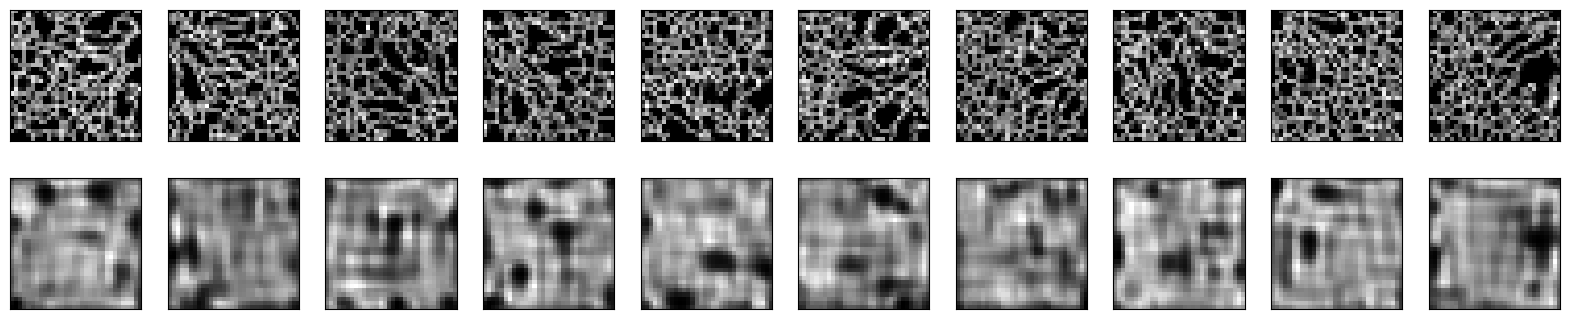

In [22]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess data
size = 32
true_size = size
print("loading...")
with np.load(f"../data{size}.npz") as set:
    data = fix_data(set["images"])  # Assuming fix_data is defined elsewhere
print(data.shape)
print(data.dtype)

# Split the data
x_train, x_test = train_test_split(data, test_size=0.4, random_state=42)

# Reshape the data for CNN (assuming grayscale images)
x_train = x_train.reshape((len(x_train), true_size, true_size, 1))
x_test = x_test.reshape((len(x_test), true_size, true_size, 1))

# Normalize the data
x_train = x_train.astype("float32") / 2
x_test = x_test.astype("float32") / 2

# Define the CNN autoencoder architecture
input_img = Input(shape=(true_size, true_size, 1))

# Encoder
x = Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
encoded = MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = Conv2D(128, (3, 3), activation="relu", padding="same")(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Create and compile the autoencoder model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

# Train the autoencoder
autoencoder.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test, x_test),
)

# Create encoder and decoder models
encoder = Model(input_img, encoded)
decoder_input = Input(shape=(size // 8, size // 8, 128))
decoder_output = autoencoder.layers[-7](decoder_input)
for i in range(-6, 0):
    decoder_output = autoencoder.layers[i](decoder_output)
decoder = Model(decoder_input, decoder_output)

# Encode and decode some test images
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

# Plot original and reconstructed images
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(true_size, true_size))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(true_size, true_size))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
